# Part III: Neural Networks Models

- Gabriel Wendell Celestino Rocha
- Alberto Bezerra de Palhares Júnior
- Joab Morais Varela
- Rafael Chaves Souto Araújo
- Eliardo Guimarães da Costa

---

## 0. Setup

In [1]:
import numpy as np
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
from matplotlib.gridspec import GridSpec
from matplotlib.font_manager import FontProperties
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.collections import PolyCollection, LineCollection

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


import warnings
warnings.filterwarnings('ignore')

- ### Aesthetic: single plot

In [2]:
%matplotlib inline

cm_font = FontProperties(fname  = 'CutiveMono-Regular.ttf')
gs_font = FontProperties(fname  = 'GillSans-Light.otf')
cm_size = 20

def sm_plot(grid = True, dark_background = False, use_tex = False, font_family = 'monospace', font_size = 15, 
            minorticks = True, major_ticks = True, minor_ticks = True, grid_linestyle = ':', grid_color = '0.50', 
            tick_length_minor = 5, tick_width_minor = 1, tick_length_major = 8, tick_width_major = 1, labelsize = 15):
    """
    Function to improve the aesthetics of Matplotlib graphs.
    """
    if dark_background:
        plt.style.use('dark_background')
    
    if grid:
        plt.grid(True, linestyle = grid_linestyle, color = grid_color, zorder = 0)
    else:
        plt.grid(False)
    
    plt.rcParams['text.usetex'] = use_tex
    plt.rcParams['font.family'] = font_family
    plt.rcParams['font.size'] = font_size
    
    if minorticks:
        plt.minorticks_on()
    else:
        plt.minorticks_off()
    
    if minor_ticks:
        plt.tick_params(axis = 'both', which = 'minor', direction = "in", 
                        top = True, right = True, length = tick_length_minor, 
                        width = tick_width_minor, labelsize = labelsize)
    
    if major_ticks:
        plt.tick_params(axis = 'both', which = 'major', direction = "in", 
                        top = True, right = True, length = tick_length_major, 
                        width = tick_width_major, labelsize = labelsize)

- ### **Aesthetics: plot axes**

In [3]:
def sm_plot_mod(ax, grid = True, dark_background = False, use_tex = False, font = 'monospace', font_size = 15, 
                minor_ticks = True, minor_tick_params = True, major_tick_params = True):
    
    if dark_background:
        plt.style.use('dark_background')
    else:
        plt.style.use('default')

    ax.grid(grid, linestyle = ':', color = '0.50')
    
    plt.rcParams['font.family'] = font
    plt.rcParams['font.size'] = font_size
    
    plt.rcParams['text.usetex'] = use_tex
    
    if minor_ticks:
        ax.minorticks_on()
    else:
        ax.minorticks_off()

    if minor_tick_params:
        ax.tick_params(axis = 'both', which = 'minor', direction = "in", 
                       top = True, right = True, length = 5, width = 1, labelsize = font_size)

    if major_tick_params:
        ax.tick_params(axis = 'both', which = 'major', direction = "in", 
                       top = True, right = True, length = 8, width = 1, labelsize = font_size)

---

## 1. Reading the Data

Reading river station, river-dam station and weather station data:

- **River station:** Kluserbrücke 
- **Weather station:** Wuppertal-Buchenhofen 
- **River-damn station:** Wupper-Talsperre 

- `data_reduced.csv`: Dataframe with all data from 1990 to 2023
- `data_reduced_weekly.csv`: Dataframe with data reduced according to a weekly average
- `data_reduced_monthly.csv`: Dataframe with data reduced according to a monthly average

In [4]:
df = pd.read_csv('Reduced_Data/data_reduced.csv', sep = ',')
df_weekly = pd.read_csv('Reduced_Data/data_reduced_weekly.csv', sep = ',')
df_monthly = pd.read_csv('Reduced_Data/data_reduced_monthly.csv', sep = ',')

df = df.rename(columns = {'  RS': 'RS'})
df = df.rename(columns = {' RSF': 'RSF'})
df.dropna()

df_weekly = df_weekly.rename(columns = {'  RS': 'RS'})
df_weekly = df_weekly.rename(columns = {' RSF': 'RSF'})
df_weekly.dropna()

df_monthly = df_monthly.rename(columns = {'  RS': 'RS'})
df_monthly = df_monthly.rename(columns = {' RSF': 'RSF'})
df_monthly.dropna()


columns_to_remove = ['RS1', 'RS2', 'RS3', 'RS7', 'RS14']
df = df.drop(columns = columns_to_remove)

df['MESS_DATUM'] = pd.to_datetime(df['MESS_DATUM'])

# -------------------------------------------------------------------------------------------------

print('River station: Kluserbrücke')
print('Weather station: Wuppertal-Buchenhofen')
print('River-damn station: Wupper-Talsperre')

print('')

print('1) All Data (1990 - 2024):', df.shape)
print('2) Weekly Average:', df_weekly.shape)
print('3) Monthly Average:', df_monthly.shape)

River station: Kluserbrücke
Weather station: Wuppertal-Buchenhofen
River-damn station: Wupper-Talsperre

1) All Data (1990 - 2024): (12062, 7)
2) Weekly Average: (1774, 12)
3) Monthly Average: (12828, 13)


---

## 2. NN Model: RNN - LSTM

### 2.1 Preprocess the data

In [5]:
# Convert MESS_DATUM to datetime format
df['MESS_DATUM'] = pd.to_datetime(df['MESS_DATUM'])

# Filter the training and test sets
train_df = df[(df['MESS_DATUM'] >= '1990-01-01') & (df['MESS_DATUM'] <= '2022-12-31')]
test_df = df[(df['MESS_DATUM'] >= '2023-01-01') & (df['MESS_DATUM'] <= '2023-12-31')]

# Features to be used for prediction
features = ['RS', 'RSF', 'DISCHARGE']
target = 'WATER-LEVEL' 

In [6]:
# Scale the features
scaler = MinMaxScaler()
train_features = scaler.fit_transform(train_df[features])
test_features = scaler.transform(test_df[features])

# Scale the target
target_scaler = MinMaxScaler()
train_target = target_scaler.fit_transform(train_df[[target]])
test_target = target_scaler.transform(test_df[[target]])

In [7]:
# Convert to sequences for LSTM
def create_sequences(features, target, time_steps = 1):
    X, y = [], []
    for i in range(len(features) - time_steps):
        X.append(features[i:(i + time_steps)])
        y.append(target[i + time_steps])
        
    return np.array(X), np.array(y)

time_steps = 10
X_train, y_train = create_sequences(train_features, train_target, time_steps)
X_test, y_test = create_sequences(test_features, test_target, time_steps)

### 2.2 Build the LSTM Model

In [8]:
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences = False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Print the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 10, 50)              │          10,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,301 (126.18 KB)

 Trainable params: 32,301 (126.18 KB)

 Non-trainable params: 0 (0.00 B)

### 2.3 Train the model

In [9]:
# Train the model
history = model.fit(X_train, y_train, epochs = 50, batch_size = 32, validation_data = (X_test, y_test))

Epoch 1/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0022 - val_loss: 0.0027
Epoch 2/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 3/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0010 - val_loss: 0.0018
Epoch 4/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0016 - val_loss: 0.0024
Epoch 5/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0010 - val_loss: 0.0023
Epoch 6/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0011 - val_loss: 0.0022
Epoch 7/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 9.2270e-04 - val_loss: 0.0024
Epoch 8/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0010 - val_loss: 0.0022
Epoch 9/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0012 - val_loss: 0.0023
Epoch 10/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0011 - val_loss: 0.0022
Epoch 11/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 12/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 4

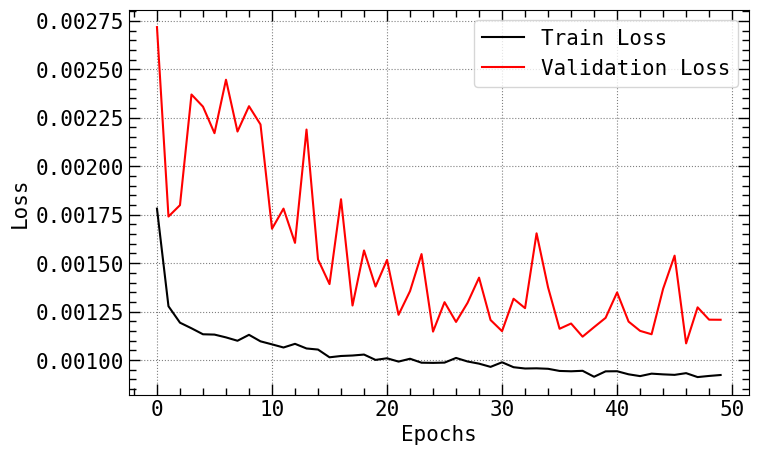

In [11]:
plt.figure(figsize = (8,5))
plt.plot(history.history['loss'], color = 'k', label = 'Train Loss')
plt.plot(history.history['val_loss'], color = 'r', label = 'Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend(loc = 'best')
sm_plot()

### 2.4 Evaluate the Model

In [12]:
# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Reverse the scaling to get actual values
train_predictions = target_scaler.inverse_transform(train_predictions)
y_train_actual = target_scaler.inverse_transform(y_train)

test_predictions = target_scaler.inverse_transform(test_predictions)
y_test_actual = target_scaler.inverse_transform(y_test)

366/366 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


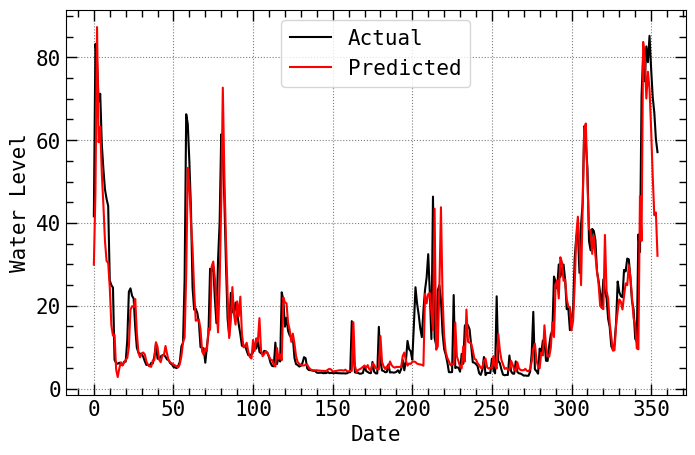

In [13]:
plt.figure(figsize = (8,5))
plt.plot(y_test_actual, color = 'k', label = 'Actual')
plt.plot(test_predictions, color = 'r', label = 'Predicted')

plt.xlabel('Date')
plt.ylabel('Water Level')

plt.legend(loc = 'best')
sm_plot()

### Notes

1. **Data Scaling:** Both the input features and the target variable are scaled using MinMaxScaler to ensure that they fit well within the range that the LSTM can handle.

2. **Sequence Creation:** The time series data is converted into sequences to enable the LSTM to learn temporal patterns.

3. **Model Architecture:** The model consists of two LSTM layers followed by a dense layer to predict the target variable. Dropout is added to prevent overfitting.

4. **Training:** The model is trained using the Adam optimizer and mean squared error as the loss function.

### 2.5 Evaluate the Metrics

In [14]:
y_true = y_test_actual
y_pred = test_predictions

# Assuming y_true are the true values and y_pred are the predictions
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared = False)
r2 = r2_score(y_true, y_pred)
explained_variance = explained_variance_score(y_true, y_pred)

# MAPE and sMAPE need custom implementations
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))

mape = mean_absolute_percentage_error(y_true, y_pred)
smape = symmetric_mean_absolute_percentage_error(y_true, y_pred)

print("1) MAE:", mae)
print("2) MSE:", mse)
print("3) RMSE:", rmse)
print("4) R^2:", r2)
print("5) Explained Variance:", explained_variance)
print("6) MAPE:", mape)
print("7) sMAPE:", smape)

1) MAE: 4.143263212929309
2) MSE: 52.83108705305302
3) RMSE: 7.268499642502091
4) R^2: 0.8275455406841612
5) Explained Variance: 0.832569953564363
6) MAPE: 27.561447270248323
7) sMAPE: 26.92209356085531
